# Neural Network From Scratch

In [56]:
%matplotlib inline

import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [57]:
#utils func
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

def spiral_gen(N,D,K):
    #N = 100 # number of points per class
    #D = 2 # dimensionality
    #K = 3 # number of classes
    X = np.zeros((N*K,D)) # data matrix (each row = single example)
    y = np.zeros(N*K, dtype='uint8') # class labels
    for j in xrange(K):
      ix = range(N*j,N*(j+1))
      r = np.linspace(0.0,1,N) # radius
      t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
      X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
      y[ix] = j
    # lets visualize the data:
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.show()
    return(X,y)

## Generate Data

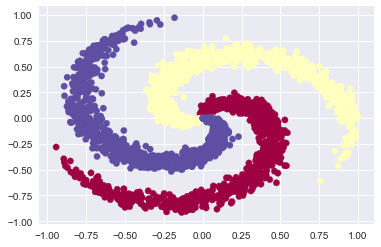

('Shape of X:', (3000, 2))
('Shape of y:', (3000,))


In [58]:
D = 2 #2 features
K = 3 #3 classes
N = 3000 #3000 total samples
X,y = spiral_gen(N/K,D,K)
print('Shape of X:',X.shape)
print('Shape of y:',y.shape)

## Softmax

Maximize the normalized probability of a class

### Initialize The Weights

In [59]:

#weight
W = np.random.randn(D,K) # features x classes
print('Weight Shape:',W.shape)
#bias
b = np.zeros((1,K))
print('Bias Shape:',b.shape)
#scores
scores = X.dot(W) + b
print('Scores Shape:',scores.shape)

('Weight Shape:', (2, 3))
('Bias Shape:', (1, 3))
('Scores Shape:', (3000, 3))


### Loss Function

#### Forward
For an example:
$$L_{i} = -log(p_{k})$$
$$p_{k} = \frac{e^{f_{k}}}{\Sigma e^{f_{j}}}$$
$$f = X_{i}W + b$$
when i = example; k = correct class; j = any class

For regularization term:
$$l2 = \frac{\lambda}{2}W^2$$
$$l1 = \frac{\lambda}{2}|W|$$

Overall Loss:
$$L = \frac{\Sigma L_{i}}{N} + l1/l2$$


In [60]:
#unnormalized prob
exp_scores = np.exp(scores)
#normalized prob
probs = exp_scores / np.sum(exp_scores, axis= 1, keepdims=True) #normalize for each sample 
print('All normalized probs:',probs.shape)
#normalized prob of correct label
correct_logprobs = -np.log(probs[range(N),y])
print('-log(normalized probs) when label is correct:',correct_logprobs.shape)
#data loss
data_loss = np.sum(correct_logprobs) / N
#reg loss
reg = 1e-3
#l2 reg
reg_loss = reg * 0.5 * np.sum(W*W)
#real loss
loss = data_loss + reg_loss

('All normalized probs:', (3000, 3))
('-log(normalized probs) when label is correct:', (3000,))


#### Backward
Derivative of loss function by weight
$$\frac{dL_{i}}{dW} = \frac{dL_{i}}{df_{k}} * \frac{df_{k}}{dW} = \frac{dL_{i}}{df_{k}} * X_{i}$$
$$\frac{dL_{i}}{df_{k}} = \frac{-dlog(p_{k})}{df_{k}} = \frac{-1}{p_{k}}\frac{dp_{k}}{df_{k}} = \frac{-1}{p_{k}}\frac{d(\frac{e^{f_{k}}}{\Sigma e^{f_{j}}})}{df_{k}}$$
$$\frac{d(\frac{e^{f_{k}}}{\Sigma e^{f_{j}}})}{df_{k}} = 
\frac{\Sigma e^{f_{j}}e^{f_{k}} - e^{2f_{k}}}{(\Sigma e^{f_{j}})^2} = p_{k} - p_{k}^2 = 
p_{k}(1-p_{k})$$
$$\frac{dL_{i}}{df_{k}} = p_{k} - 1(y_{i}=k)$$
$$\frac{dL_{i}}{dW} = [p_{k} - 1(y_{i}=k)] * X_{i}$$


In [61]:
#p_k
dscores = probs
#minus only when class is correct
dscores[range(N),y]-=1
#normalize by number of samples
dscores /= N
print('dScores Shape:',dscores.shape)
dW = X.T.dot(dscores)
#derivative of regulariaation term
dW += reg * W
print('dW Shape:',dW.shape) # feature x class
db = np.sum(dscores, axis=0, keepdims=True)
print('db Shape:',db.shape) # one constant for each class

('dScores Shape:', (3000, 3))
('dW Shape:', (2, 3))
('db Shape:', (1, 3))


#### Back and Forth

In [62]:
#Initialization
#weight
W = np.random.randn(D,K) # features x classes
print('Weight Shape:',W.shape)
#bias
b = np.zeros((1,K))
print('Bias Shape:',b.shape)
#scores
scores = X.dot(W) + b
print('Scores Shape:',scores.shape)
reg = 1e-3
step_size = 1e-0

for i in np.arange(150):
    #forward pass
    scores = X.dot(W) + b 
    #unnormalized prob
    exp_scores = np.exp(scores)
    #normalized prob
    probs = exp_scores / np.sum(exp_scores, axis= 1, keepdims=True) #normalize for each sample 
    #normalized prob of correct label
    correct_logprobs = -np.log(probs[range(N),y])
    #data loss
    data_loss = np.sum(correct_logprobs) / N
    #l2 reg
    reg_loss = reg * 0.5 * np.sum(W*W)
    #real loss
    loss = data_loss + reg_loss
    
    if i % 10 == 0:
        print "iteration %d: loss %f" % (i, loss)
    
    #backward pass
    dscores = probs
    #minus only when class is correct
    dscores[range(N),y]-=1
    #normalize by number of samples
    dscores /= N
    dW = X.T.dot(dscores)
    #derivative of regulariaation term
    dW += reg * W
    db = np.sum(dscores, axis=0, keepdims=True)
    
    #update weights
    W += -step_size * dW
    b += -step_size * db

('Weight Shape:', (2, 3))
('Bias Shape:', (1, 3))
('Scores Shape:', (3000, 3))
iteration 0: loss 1.500342
iteration 10: loss 1.032850
iteration 20: loss 0.878819
iteration 30: loss 0.820625
iteration 40: loss 0.793743
iteration 50: loss 0.779565
iteration 60: loss 0.771415
iteration 70: loss 0.766443
iteration 80: loss 0.763277
iteration 90: loss 0.761195
iteration 100: loss 0.759791
iteration 110: loss 0.758826
iteration 120: loss 0.758151
iteration 130: loss 0.757672
iteration 140: loss 0.757329


#### Prediction
Choose the class with highest unno

In [63]:
def pred1(X):
    pred = np.argmax(np.exp(X.dot(W) + b),axis=1)
    print 'training accuracy: %.2f' % (np.mean(pred == y))
    return pred
pred = pred1(X)

training accuracy: 0.52


training accuracy: 0.00


/Users/charin.polpanumas/venv/data-science/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


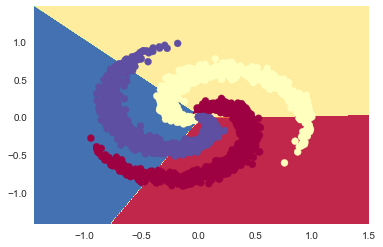

In [64]:
plot_decision_boundary(pred1)

## SVM

Maximizes the margin between two classes with hyperparameter delta

### Forward

For an example:

Loss per class per example is positive only when the score of wrong class is more than score of correct class by delta.
$$L_{i} = \Sigma max(0,f_{j} - f_{k} + \Delta)$$
where j != k

### Backward
Derivative of loss function by weight
$$\frac{dL_{i}}{dW} = \frac{dL_{i}}{df_{j-or-k}} * \frac{df_{j-or-k}}{dW} = \frac{dL_{i}}{df_{j-or-k}} * X_{i}$$

Minus sum of everything that has enough delta
$$\frac{dL_{i}}{df_{k}} = -\Sigma 1(f_{j} - f_{k} + \Delta)$$

Plus one for any other arbitrary classes
$$\frac{dL_{i}}{df_{j}} = 1(f_{j} - f_{k} + \Delta > 0)$$

In [65]:
#Initialization
#weight
W = np.random.randn(D,K) # features x classes
print('Weight Shape:',W.shape)
print('Bias Shape:',b.shape)
#scores
scores = X.dot(W)
print('Scores Shape:',scores.shape)
reg = 1e-3
step_size = 1e-0
delta = 1e-0

for i in np.arange(150):
    #forward pass
    scores = X.dot(W)
    #get correct class
    correct_scores = scores[range(N),y]
    margin = scores.T - correct_scores + delta # can broadcast by row not columns
    margin = margin.T
    margin[range(N),y] = 0 #zero loss at the correct label
    margin = np.maximum(np.zeros(margin.shape),margin) #element-wise max
    data_loss = np.sum(margin) / N
    
    #l2 reg
    reg_loss = reg * 0.5 * np.sum(W*W)
    #real loss
    loss = data_loss + reg_loss
    
    if i % 10 == 0:
        print "iteration %d: loss %f" % (i, loss)
    
    #backward pass
    binary = margin
    binary[margin>1] = 1
    col_sum = np.sum(binary,axis=1)
    binary[range(N),y] -= col_sum[range(N)]
    dW = X.T.dot(binary)
    dW /= N
    #derivative of regulariaation term
    dW += reg * W

    #update weights
    W += -step_size * dW

('Weight Shape:', (2, 3))
('Bias Shape:', (1, 3))
('Scores Shape:', (3000, 3))
iteration 0: loss 2.283338
iteration 10: loss 1.259150
iteration 20: loss 1.156528
iteration 30: loss 1.143825
iteration 40: loss 1.137880
iteration 50: loss 1.134750
iteration 60: loss 1.133071
iteration 70: loss 1.132148
iteration 80: loss 1.131632
iteration 90: loss 1.131341
iteration 100: loss 1.131176
iteration 110: loss 1.131082
iteration 120: loss 1.131027
iteration 130: loss 1.130994
iteration 140: loss 1.130975


#### Prediction

training accuracy: 0.00


/Users/charin.polpanumas/venv/data-science/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


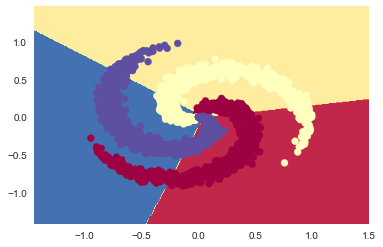

In [66]:
plot_decision_boundary(pred1)

## ReLu + Softmax

### Initialize The Weights

In [67]:
# initialize parameters randomly
#relu layer
h = 100 # number of nodes
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
print('Shape of W:',W.shape)
print('Shape of b:',b.shape)
#sigmoid layer
W2 = 0.01 * np.random.randn(h,K) 
b2 = np.zeros((1,K))
print('Shape of W2:',W2.shape)
print('Shape of b2:',b2.shape)

('Shape of W:', (2, 100))
('Shape of b:', (1, 100))
('Shape of W2:', (100, 3))
('Shape of b2:', (1, 3))


### Forward

Input(N,D) dot ReLu Weight (D,H) dot Softmax Weight (H,C)

$$O_{1} = max(0,X_{i}*W_{1} + b_{1})$$
$$O_{2} = O_{1,j-or-k}*W_{2} + b_{2}$$
$$p_{k} = \frac{e^{O_{2,k}}}{\Sigma e^{O_{2,j}}}$$
$$L_{i} = -log(p_{k})$$

In [68]:
hidden_layer = np.maximum(0,X.dot(W) + b) #relu; element-wise max
print('Shape of hidden layer:',hidden_layer.shape)
scores = hidden_layer.dot(W2) + b2
print('Shape of scores:',scores.shape)
exp_scores = np.exp(scores)
probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
print('Shape of probs:',probs.shape)
corect_logprobs = -np.log(probs[range(N),y])
data_loss = np.sum(corect_logprobs)/N

#two regularizations
reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
loss = data_loss + reg_loss

('Shape of hidden layer:', (3000, 100))
('Shape of scores:', (3000, 3))
('Shape of probs:', (3000, 3))


### Backward
$$\frac{dL_{i}}{dW_{2}} = \frac{dL_{i}}{dO_{2}} * \frac{dO_{2}}{dW_{2}} = [p_{k} - 1(y_{i}=k)] * O_{1}$$

$$\frac{dL_{i}}{dW_{1}} = \frac{dL_{i}}{dO_{2}} * \frac{dO_{2}}{dO_{1}} * \frac{dO_{1}}{dW_{1}} = [p_{k} - 1(y_{i}=k)] * W_{2} * X_{i}(O_{1} > 0) $$

In [69]:
dscores = probs
dscores[range(N),y] -= 1
dscores /= N
dW2 = hidden_layer.T.dot(dscores)
dW2 += reg * W2
print('Shape of dW2',dW2.shape)
db2 = np.sum(dscores, axis=0, keepdims=True)
print('Shape of db2',db2.shape)

#chain back until hidden layer
dhidden = dscores.dot(W2.T)
#relu if x <= 0 then 0
dhidden[hidden_layer <= 0] = 0
print('Shape of dhidden',dhidden.shape)
dW = np.dot(X.T, dhidden)
dW += reg * W
print('Shape of dW',dW.shape)
db = np.sum(dhidden, axis=0, keepdims=True)
print('Shape of b',db.shape)

('Shape of dW2', (100, 3))
('Shape of db2', (1, 3))
('Shape of dhidden', (3000, 100))
('Shape of dW', (2, 100))
('Shape of b', (1, 100))


### Back and Forth

In [70]:
# initialize parameters randomly
#relu layer
h = 100 # number of nodes
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
#sigmoid layer
W2 = 0.01 * np.random.randn(h,K) 
b2 = np.zeros((1,K))

for i in np.arange(10000):
    #forward
    hidden_layer = np.maximum(0,X.dot(W) + b) #relu; element-wise max
    scores = hidden_layer.dot(W2) + b2
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    corect_logprobs = -np.log(probs[range(N),y])
    data_loss = np.sum(corect_logprobs)/N

    #two regularizations
    reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
    loss = data_loss + reg_loss
        
    if i % 1000 == 0:
        print "iteration %d: loss %f" % (i, loss)
    
    #backward
    dscores = probs
    dscores[range(N),y] -= 1
    dscores /= N
    dW2 = hidden_layer.T.dot(dscores)
    dW2 += reg * W2
    db2 = np.sum(dscores, axis=0, keepdims=True)

    #chain back until hidden layer
    dhidden = dscores.dot(W2.T)
    #relu if x <= 0 then 0
    dhidden[hidden_layer <= 0] = 0
    dW = np.dot(X.T, dhidden)
    dW += reg * W
    db = np.sum(dhidden, axis=0, keepdims=True)
    
    #update
    W -= step_size * dW
    b -= step_size * db
    W2 -= step_size * dW2
    b2 -= step_size * db2
    

iteration 0: loss 1.098606
iteration 1000: loss 0.442068
iteration 2000: loss 0.307936
iteration 3000: loss 0.256276
iteration 4000: loss 0.253901
iteration 5000: loss 0.253030
iteration 6000: loss 0.252362
iteration 7000: loss 0.251791
iteration 8000: loss 0.251201
iteration 9000: loss 0.249881


### Prediction

In [71]:
def pred2(X):
    hidden_layer = np.maximum(0, np.dot(X, W) + b)
    scores = np.dot(hidden_layer, W2) + b2
    pred = np.argmax(scores, axis=1)
    print 'training accuracy: %.2f' % (np.mean(pred == y))
    return pred
pred = pred2(X)

training accuracy: 0.99


training accuracy: 0.00

/Users/charin.polpanumas/venv/data-science/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  """


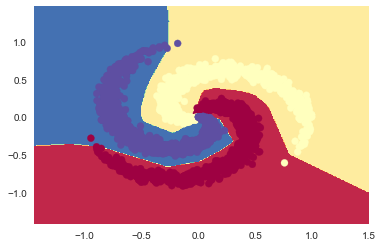

In [72]:
plot_decision_boundary(pred2)

## Optimization

- Vanilla
- Stochastic: one by one or by batch
- Momentum: accelerate in relevant directions; incorporate decaying average of past gradients

$$\frac{dL_{i}}{dW} = \alpha * \frac{dL_{i}}{dW} + \beta * \frac{dL_{i-1}}{dW}$$

- adagrad: adaptive learning rate per parameter; divide by sqrt of average of past squared gradient 

$$learn_{\beta} = \frac{learn_{base}}{\sqrt{\Sigma (\frac{dL}{d\beta})^2}}$$

- rmsprop: adaptive learning rate per parameter; exponentially decaying average of past squared gradient

$$learn_{\beta} = \frac{learn_{base}}{\gamma * rms_{current} + \nu * rms_{previous}}$$

- adam: rmsprop + momentum
- eve: anneal learning rate based on recent volatility of loss; divide it by dt

$$ r_{t} = \frac{|loss_{t} - loss_{t-1}|}{max(loss_{t},loss_{t-1})}$$
$$ dt = \gamma * r{t} + \nu * r_{t-1} $$

- adam_ann: eve with average sum of squares of gradients instead of loss

